## Import libraries

In [1]:
# data manipulation
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

# linear algebra
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
plt.rcParams['figure.figsize'] = 12,6
sns.set_style('darkgrid')
%matplotlib inline

# machine leanring
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, recall_score, precision_score, make_scorer, precision_recall_curve

import math
from time import time

### Import dataset

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data_duration = df['Time'].max() / (60*60)
fraud_cost = round(df[df['Class']==1]['Amount'].mean(),2)
number_of_transactions_per_hour = 12 # one transaction per 5 minutes
monitoring_cost = 6780 / (4*40) / number_of_transactions_per_hour # (4*40) means to 40 working hours per week for 4 weeks

print(f'This data is worth {round(data_duration)} hours of transactions.')
print(f'The average fraud cost is RM {fraud_cost}')
print('I am assuming the salary of financial staff in Malaysia is RM 6780.')
print('I am also assuming that one transaction takes 5 minutes to be checked.')
print(f'So, the monitoring cost for one transaction is RM {round(monitoring_cost,2)}')

This data is worth 48 hours of transactions.
The average fraud cost is RM 122.21
I am assuming the salary of financial staff in Malaysia is RM 6780.
I am also assuming that one transaction takes 5 minutes to be checked.
So, the monitoring cost for one transaction is RM 3.53


In [4]:
print(f'For every fraud transaction predicted by our model, monitoring will be done.')
print(f'But if our model predicted a fraud transaction as normal, then we will loss RM {fraud_cost}.')

For every fraud transaction predicted by our model, monitoring will be done.
But if our model predicted a fraud transaction as normal, then we will loss RM 122.21.


## Model building

In [5]:
def create_models():
    models = {}
    models['Logistic Regression'] = LogisticRegression(max_iter=5000)
    models['K-Nearest Neighbors'] = KNeighborsClassifier()
    models['Support Vector Machines'] = SVC()
    models['Decision Tree'] = DecisionTreeClassifier()
    models['Naive Bayes'] = GaussianNB()
    models['Random Forest'] = RandomForestClassifier()
    return models

In [6]:
def evaluate_model(model, X, y, metrics='accuracy'):
    scaler = StandardScaler()
    pipeline = Pipeline(steps=[('scaler', scaler),('model', model)])
    cv = StratifiedKFold(5,shuffle=True,random_state=143)
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=metrics)
    return scores

In [7]:
def false_positive(estimator, X, y):
    predictions = estimator.predict(X)
    cm = confusion_matrix(y,predictions)
    return cm[0][1]

def false_negative(estimator, X, y):
    predictions = estimator.predict(X)
    cm = confusion_matrix(y,predictions)
    return cm[1][0]

def true_positive(estimator, X, y):
    predictions = estimator.predict(X)
    cm = confusion_matrix(y,predictions)
    return cm[1][1]

In [8]:
df = df.iloc[:,1:]
X = df.drop('Class', axis=1)
y = df['Class']

names = []
results = []

scoring = {'fp':false_positive,
           'fn':false_negative,
           'tp':true_positive,
           'recall': 'recall',
           'precision': 'precision',
           'f1_score': 'f1'}

for name, model in create_models().items():
    print(f'--- Initializing {name} ---')
    scores = evaluate_model(model, X, y, scoring)
    names.append(name)
    results.append(scores)
    print(f'--- {name} done! ---')

--- Initializing Logistic Regression ---
--- Logistic Regression done! ---
--- Initializing K-Nearest Neighbors ---
--- K-Nearest Neighbors done! ---
--- Initializing Support Vector Machines ---
--- Support Vector Machines done! ---
--- Initializing Decision Tree ---
--- Decision Tree done! ---
--- Initializing Naive Bayes ---
--- Naive Bayes done! ---
--- Initializing Random Forest ---
--- Random Forest done! ---


In [9]:
test_fp = []
test_fn = []
test_tp = []
test_recall = []
test_precision = []
test_f1 = []
time_taken = []

for i in range(len(results)):
    test_fp.append(results[i]['test_fp'].mean())

for i in range(len(results)):
    test_fn.append(results[i]['test_fn'].mean())

for i in range(len(results)):
    test_tp.append(results[i]['test_tp'].mean())

for i in range(len(results)):
    test_recall.append(results[i]['test_recall'].mean())

for i in range(len(results)):
    test_precision.append(results[i]['test_precision'].mean())

for i in range(len(results)):
    test_f1.append(results[i]['test_f1_score'].mean())

for i in range(len(results)):
    time_taken.append(round(results[i]['score_time'].sum(),1) + round(results[i]['fit_time'].sum(),1))

test_fn = pd.Series(test_fn,name='False negative')
test_fp = pd.Series(test_fp,name='False positive')
test_tp = pd.Series(test_tp,name='True positive')
test_recall = pd.Series(test_recall,name='Recall')
test_precision = pd.Series(test_precision,name='Precision')
test_f1 = pd.Series(test_f1,name='F1-score')
time_taken = pd.Series(time_taken,name='Time to compute (seconds)')

df_result = pd.concat([test_fp,test_fn,test_tp,test_recall,test_precision,test_f1,time_taken], axis=1)
df_result.index = names
df_result['Cost function (RM)'] = round(df_result['False negative'] * fraud_cost + ((df_result['True positive'] + df_result['False positive']) * monitoring_cost),2)
df_result = df_result.iloc[:,[0,1,2,3,4,5,7,6]]
df_result.sort_values(['Cost function (RM)','F1-score'])

,False positive,False negative,True positive,Recall,Precision,F1-score,Cost function (RM),Time to compute (seconds)
Random Forest,5.4,21.4,77.0,0.782560,0.935981,0.851794,2906.27,1057.5
K-Nearest Neighbors,6.8,21.8,76.6,0.778437,0.918710,0.842548,2958.68,6494.0
Decision Tree,22.0,22.8,75.6,0.768275,0.776378,0.771336,3131.04,96.0
Support Vector Machines,4.0,34.6,63.8,0.648341,0.943000,0.767628,4467.88,2334.9
Logistic Regression,9.2,37.8,60.6,0.615997,0.870195,0.717379,4866.02,13.8
Naive Bayes,1246.2,16.8,81.6,0.829272,0.061520,0.114525,6741.92,3.9


## Hyperparameter tuning

In [10]:
param_grid = {}
param_grid['model__max_leaf_nodes'] = [15,16,17]
param_grid['model__min_samples_leaf'] = [8,9,10]
param_grid['model__min_impurity_decrease'] = [1e-04,1e-05,1e-06]

In [11]:
model = DecisionTreeClassifier()
scaler = StandardScaler()

pipeline = Pipeline(steps=[('scaler', scaler),('model', model)])
cv = StratifiedKFold(5,shuffle=True,random_state=143)
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, refit=True)

grid.fit(X, y)
grid.best_params_

{'model__max_leaf_nodes': 15,
 'model__min_impurity_decrease': 1e-05,
 'model__min_samples_leaf': 8}

## Threshold Analysis

In [13]:
def evaluate_model(model, X, y):
    scaler = StandardScaler()
    pipeline = Pipeline(steps=[('scaler', scaler), ('model', model)])
    cv = StratifiedKFold(5, shuffle=True, random_state=143)
    scores = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')
    return scores

In [14]:
model = DecisionTreeClassifier(max_leaf_nodes=15,min_samples_leaf=8,min_impurity_decrease=1e-05)
proba = evaluate_model(model, X, y)

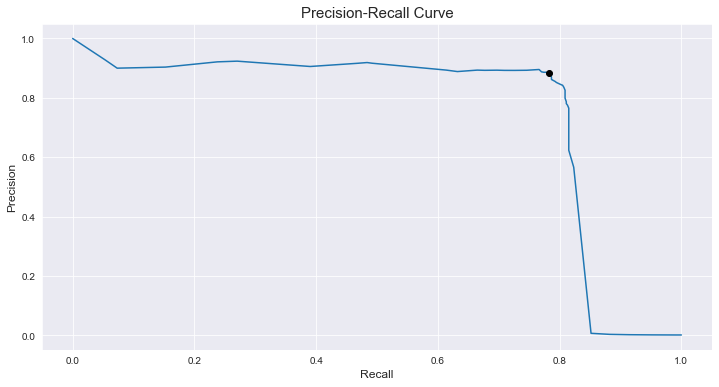

In [15]:
precision, recall, threshold = precision_recall_curve(y, proba[:,1])

fscore = (2 * precision * recall) / (precision + recall)
idx = np.argmax(fscore)

plt.figure(figsize=(12,6))
plt.plot(recall, precision)
plt.plot(recall[idx], precision[idx], marker='o', color='black')
plt.title('Precision-Recall Curve', fontsize=15)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12);

In [16]:
print(f'Threshold: {threshold[idx]}')
print(f'Recall: {recall[idx]:20}')
print(f'Precision: {precision[idx]}')
print(f'F1-score: {fscore[idx]:19}')

Threshold: 0.5
Recall:    0.782520325203252
Precision: 0.8850574712643678
F1-score:  0.8306364617044227


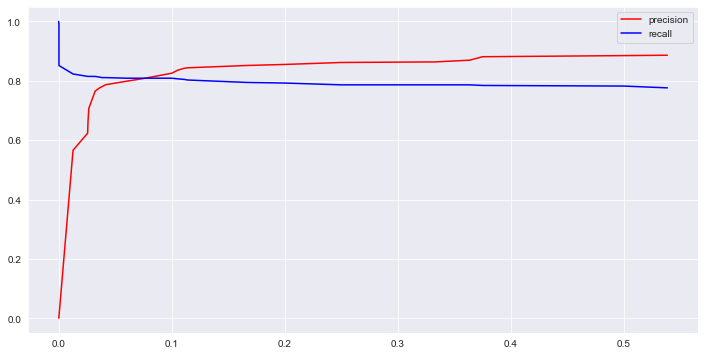

In [17]:
recall_idx = np.where(recall >= 0.774397)
recall = recall[recall_idx]
precision = precision[recall_idx]
threshold = threshold[recall_idx]

fscore = (2 * precision * recall) / (precision + recall)
idx = np.argmax(fscore)

plt.figure(figsize=(12,6))
plt.plot(threshold, precision, color='red', label='precision')
plt.plot(threshold, recall, color='blue', label='recall')
plt.legend();

In [18]:
print(f'Threshold: {threshold[idx]}')
print(f'Recall: {recall[idx]:20}')
print(f'Precision: {precision[idx]}')
print(f'F1-score: {fscore[idx]:19}')

Threshold: 0.5
Recall:    0.782520325203252
Precision: 0.8850574712643678
F1-score:  0.8306364617044227


In [19]:
pred = np.where(proba[:,1] >= threshold[idx], 1, 0)
confusion_matrix(y, pred)

array([[284265,     50],
       [   107,    385]], dtype=int64)

In [21]:
(tn, fp), (fn, tp) = confusion_matrix(y, pred)

print(f'Cost function: RM {round((fn/5) * fraud_cost + (((tp + fp)/5) * monitoring_cost),2)}')
print(f'Money saved: {round(((3041.19 - 2898.78) / 3041.19) * 100, 2):6} %')

Cost function: RM 2922.51
Money saved:   4.68 %


In [22]:
start = time()
model.fit(X,y)
end = time()

round(end-start,1)

5.5

## Borderline SMOTE SVM

In [24]:
from imblearn.over_sampling import SVMSMOTE

borderline_svm = SVMSMOTE()
X_svm,y_svm = borderline_svm.fit_resample(X,y)

In [25]:
tree_scoring = {'recall':'recall',
                'precision':'precision',
                'f1-score':'f1'}

def evaluate_model(model, X, y, metrics='accuracy'):
    scaler = StandardScaler()
    pipeline = Pipeline(steps=[('scaler', scaler),('model', model)])
    cv = StratifiedKFold(5,shuffle=True,random_state=143)
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=metrics)
    return scores

tree_scores = evaluate_model(DecisionTreeClassifier(), X_svm, y_svm, tree_scoring)

In [26]:
tree_recall = math.floor(tree_scores['test_recall'].mean() * 10 ** 5) / 10 ** 5
tree_precision = math.floor(tree_scores['test_precision'].mean() * 10 ** 5) / 10 ** 5
tree_f1 = math.floor(tree_scores['test_f1-score'].mean() * 10 ** 5) / 10 ** 5

In [27]:
print(f'Recall: {tree_recall * 100:9} %')
print(f'Precision: {tree_precision * 100:.3f} %')
print(f'F1-score: {tree_f1 * 100:7} %')

Recall:    99.959 %
Precision: 99.903 %
F1-score:  99.931 %
